# Create Paper Ready Figures

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from scipy.stats import lognorm, norm, ttest_ind, shapiro, levene, mannwhitneyu
from collections import Counter
import os, sys

%matplotlib ipympl

## Data

### Data Extraction and Training Steps
1. run_me_first.py: programmatically download RRUFF database of Raman spectrum for the excellent_oriented, excellent_unoriented, fair_oriented, and fair_unoriented data as well as the microprobe chemistry data.
2. extract_spectra_wavenumber_cutoffs.py: load and process Raman spectrum from RRUFF downloads including interpolating to the corrected wavenumber range with a linear interpolation and normalizing the spectrum from 0 to 1. Data is saved in 'extracted_data_wavenumber_cutoffs/'
3. extract_chemistry.py: loop through all microprobe data, find required chemistry, and save chemistry in numpy arrays 'extracted_chemistry_avg.npy'
4. extract_density.py: extract and process all density and hardness data saving processed data in 'extracted_density.npy' and 'extracted_hardness.npy'
5. combine_chem_spectra.py: loads spectra from 'extracted_data_wavenumber_cutoffs/', chemistry from 'extracted_chemistry_avg.npy', and density/hardness from 'extracted_density' and 'extracted_hardness'; matches ids for spectra, chemistry, and density/hardness; generates ready training data for both the raw and processed spectrum with combined chemistry, density, and hardness; and saves the data in the directory 'train_data_wavenumber_cutoffs_density_hardness/'
6. main_train_unique_names.py: loads ready processed 'proc' training data from 'train_data_wavenumber_cutoffs_density_hardness/'; loops through the unique mineral names leaving out one unique mineral name for each training run; training a model on all data except the left out sample; making a prediction on the left out mineral; and saving that single prediction before going to the next unique mineral name. 

- Raman spectrum from RRUFF database (using processed spectrum here, excellent and fair oriented and unoriented data) (https://rruff.info/zipped_data_files/)
- density and hardness from the Mineralogy Database (https://webmineral.com/)
- wavenumber cutoffs (50 - 1700) with 1024 points
- wavenumber = np.linspace(50, 1700, 1024, endpoint=True)
- tm.customDataset with added noise (uniform noise added to each spectrum in each training epoch between 0 and 2%, no noise added to the left out mineral)
- NAdam Optimizer with a learning rate of 0.001
- batch size = 64
- epochs = 100
- MSE loss function mean((predicted spectrum - true spectrum) ** 2)
- hyperparameter tuning was not the purpose here, but changing optimizers, the loss function, network model (ANN, FCN, CNN), depth and breadth after finding a model architecture that learned reasonably well for each architecture, did not have a large impact on the final result. The work here shows results for a standard fully connected network
- PyTorch
- fully connected network architecture: 5 linear layers starting with the input size of 22 (20 chemistry + density + hardness) to size of 64, then 64 -> 128, 128 -> 256, 256->512, and 512 -> 1024 (output size). each layer uses a relu activation function except for the last layer which is the correct spectrum shape of 1024

### Load Data

In [2]:
print("DATA FROM TRAINING IN FILE: 'main_train_unique_names.py'\n")

## Load the Data that includes Density and Hardness
basepath = "results_trained_FeedForward_density_hardness_unique_names" + os.path.sep

chem_dh = np.load(basepath + "all_chem.npy", allow_pickle=True)
names_dh = np.load(basepath + "all_names.npy", allow_pickle=True)
rruffid_dh = np.load(basepath + "all_rruffid.npy", allow_pickle=True)
spec_predicted_dh = np.load(basepath + "all_spectra_predictions.npy", allow_pickle=True)
spec_true_dh = np.load(basepath + "all_spectra.npy", allow_pickle=True)

# Print Data shapes
print("- INCLUDING DENSITY AND HARDNESS -")
print("chemistry shape: ", chem_dh.shape)
print("mineral names shape: ", names_dh.shape)
print("rruffid shape: ", rruffid_dh.shape)
print("spec_predicted shape: ", spec_predicted_dh.shape)
print("spec_true shape: ", spec_true_dh.shape)

unique_minerals_dh = np.unique(names_dh)
print("Number of unique mineral names dh: ", len(unique_minerals_dh))


## Load the Data that does NOT include Density and Hardness
basepath = "results_trained_FeedForward_unique_names" + os.path.sep

chem = np.load(basepath + "all_chem.npy", allow_pickle=True)
names = np.load(basepath + "all_names.npy", allow_pickle=True)
rruffid = np.load(basepath + "all_rruffid.npy", allow_pickle=True)
spec_predicted = np.load(basepath + "all_spectra_predictions.npy", allow_pickle=True)
spec_true = np.load(basepath + "all_spectra.npy", allow_pickle=True)

# Print Data shapes
print("\n- WITHOUT DENSITY AND HARDNESS -")
print("chemistry shape: ", chem.shape)
print("mineral names shape: ", names.shape)
print("rruffid shape: ", rruffid.shape)
print("spec_predicted shape: ", spec_predicted.shape)
print("spec_true shape: ", spec_true.shape)

unique_minerals = np.unique(names)
print("Number of unique mineral names: ", len(unique_minerals))


names_oxides = np.load('extracted_chemistry_oxide_names.npy', allow_pickle=True)
names_oxides_dh = np.append(names_oxides, ['d', 'h'])
print("\nOxide Names {}: ".format(names_oxides.shape))

for i in range(len(names_oxides_dh)):
    name = names_oxides_dh[i]
    print("{}\t{}".format(i+1, name))


# Load wavenumber min / max arrays
wavenumber_mins = np.load("extracted_data_wavenumber_cutoffs" + os.path.sep + "wavenumber_mins.npy", allow_pickle=True)
wavenumber_maxs = np.load("extracted_data_wavenumber_cutoffs" + os.path.sep + "wavenumber_maxs.npy", allow_pickle=True)

print("\nwavenumber mins shape: ", wavenumber_mins.shape)
print("wavenumber maxs shape: ", wavenumber_maxs.shape)

DATA FROM TRAINING IN FILE: 'main_train_unique_names.py'

- INCLUDING DENSITY AND HARDNESS -
chemistry shape:  (4005, 22)
mineral names shape:  (4005,)
rruffid shape:  (4005,)
spec_predicted shape:  (4005, 1024)
spec_true shape:  (4005, 1024)
Number of unique mineral names dh:  658

- WITHOUT DENSITY AND HARDNESS -
chemistry shape:  (4005, 20)
mineral names shape:  (4005,)
rruffid shape:  (4005,)
spec_predicted shape:  (4005, 1024)
spec_true shape:  (4005, 1024)
Number of unique mineral names:  658

Oxide Names (20,): 
1	Al2O3
2	As2O5
3	BaO
4	CO2
5	CaO
6	Cr2O3
7	CuO
8	Fe2O3
9	FeO
10	K2O
11	MgO
12	MnO
13	Na2O
14	P2O5
15	PbO
16	SO3
17	SiO2
18	SrO
19	TiO2
20	ZnO
21	d
22	h

wavenumber mins shape:  (10904,)
wavenumber maxs shape:  (10904,)


### Investigate Data

(658,) (658, 1024) (658, 1024) (658, 20)
(658,) (658, 1024) (658, 1024) (658, 22)

Shapiro-Wilk Test, the data for both distributions is not Normal (p << 0.05)
MSE DH p-value: 3.35e-09
MSE p-value: 7.13e-09

Levene equal variance test (p > 0.05 means variances are similar)
Equal Variance p-value: 0.27292


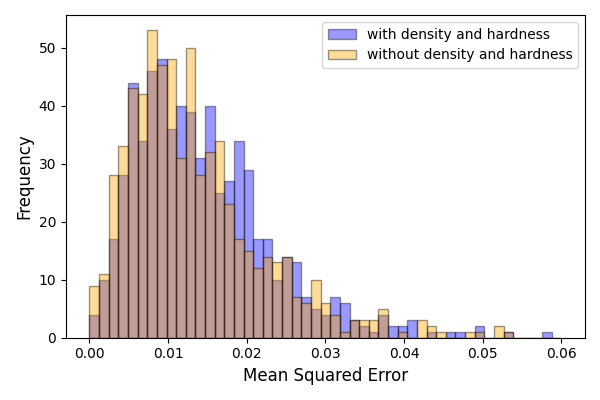

u-statistic: 235341.00000
p-value: 0.00622352

A small p-value (typically < 0.05) tells you that the observed difference between two datasets (or between your data and a model) is unlikely to have occurred by random chance under the null hypothesis.


In [3]:
# Find the MSE for each predicted spectrum and order the spectra by the highest to lowest MSE.
# Are there any similarities between the low MSE predictions and are there any similarities between the high MSE spectrum?

# Group by mineral name for averaging spec_true (and spec_predicted although they are all equal for a specific mineral)

## Without density and hardness
# Convert to DataFrame for grouping
df_true = pd.DataFrame(spec_true)
df_pred = pd.DataFrame(spec_predicted)
df_chem = pd.DataFrame(chem)
df_true['name'] = names
df_pred['name'] = names
df_chem['name'] = names

# Group by 'name' and compute mean
spec_true_avg_df = df_true.groupby('name').mean()
spec_predicted_avg_df = df_pred.groupby('name').mean()
chem_avg_df = df_chem.groupby('name').mean()

# Extract values
names_avg = spec_true_avg_df.index.to_numpy()
spec_true_avg = spec_true_avg_df.to_numpy()
spec_predicted_avg = spec_predicted_avg_df.to_numpy()
chem_avg = chem_avg_df.to_numpy()

print(names_avg.shape, spec_true_avg.shape, spec_predicted_avg.shape, chem_avg.shape)


## With density and hardness
# Convert to DataFrame for grouping
df_true = pd.DataFrame(spec_true_dh)
df_pred = pd.DataFrame(spec_predicted_dh)
df_chem = pd.DataFrame(chem_dh)
df_true['name'] = names_dh
df_pred['name'] = names_dh
df_chem['name'] = names_dh

# Group by 'name' and compute mean
spec_true_avg_df = df_true.groupby('name').mean()
spec_predicted_avg_df = df_pred.groupby('name').mean()
chem_avg_df = df_chem.groupby('name').mean()

# Extract values
names_dh_avg = spec_true_avg_df.index.to_numpy()
spec_true_dh_avg = spec_true_avg_df.to_numpy()
spec_predicted_dh_avg = spec_predicted_avg_df.to_numpy()
chem_dh_avg = chem_avg_df.to_numpy()

print(names_dh_avg.shape, spec_true_dh_avg.shape, spec_predicted_dh_avg.shape, chem_dh_avg.shape)

# All MSE
#mse_dh = np.mean((spec_predicted_dh - spec_true_dh) ** 2, axis=1)
#mse = np.mean((spec_predicted - spec_true) ** 2, axis=1)

# Average Spectrum MSE
mse_dh = np.mean((spec_predicted_dh_avg - spec_true_dh_avg) ** 2, axis=1)
mse = np.mean((spec_predicted_avg - spec_true_avg) ** 2, axis=1)

# Test if log distributions are normal using Shapiro-Wilk Test
log_mse_dh = np.log(mse_dh)
log_mse = np.log(mse)

stat_mse_dh, p_mse_dh = shapiro(log_mse_dh)
stat_mse, p_mse = shapiro(log_mse)

print("\nShapiro-Wilk Test, the data for both distributions is not Normal (p << 0.05)")
print("MSE DH p-value: {:.2e}".format(p_mse_dh))
print("MSE p-value: {:.2e}".format(p_mse))


# Test if the distributions have equal variance
stat, p = levene(log_mse_dh, log_mse)
print("\nLevene equal variance test (p > 0.05 means variances are similar)")
print("Equal Variance p-value: {:.5}".format(p))

# Fit log-normal distribution
# with density and hardness
#shape_dh, loc_dh, scale_dh = lognorm.fit(mse_dh, floc=0)
#x_dh = np.linspace(min(mse_dh), max(mse_dh), 1000)
#pdf_fitted_dh = lognorm.pdf(x_dh, shape_dh, loc=loc_dh, scale=scale_dh)

# without density and hardness
#shape, loc, scale = lognorm.fit(mse, floc=0)
#x = np.linspace(min(mse), max(mse), 1000)
#pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
bins = np.linspace(0, 0.06, 50, endpoint=True)

ax.hist(mse_dh, bins=bins, density=False, edgecolor='black', facecolor='blue', alpha=0.4, label='with density and hardness')
#ax.plot(x_dh, pdf_fitted_dh, color='blue', linestyle='-', lw=2, label='Log-normal fit')

ax.hist(mse, bins=bins, density=False, edgecolor='black', facecolor='orange', alpha=0.4, label='without density and hardness')
#ax.plot(x, pdf_fitted, color='orange', linestyle='-', lw=2, label='Log-normal fit')

ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()  # minimizes padding
plt.show()

#print(f"Log-normal fit parameters (with density and hardness):\n shape (σ): {shape_dh:.4f}\n scale (exp(μ)): {scale_dh:.4f} \n mean (μ): {np.log(scale_dh):.4f} \n location (shift): {loc_dh:.4f}")
#print(f"\nLog-normal fit parameters:\n shape (σ): {shape:.4f}\n scale (exp(μ)): {scale:.4f} \n mean (μ): {np.log(scale):.4f} \n location (shift): {loc:.4f}")


# Cannot use t-test below b/c distributions are not normal
# t-test on log-values (compares means of two groups to help determine if the difference between the group means is statistically significant)
#t_stat, p_val = ttest_ind(log_mse, log_mse_dh, equal_var=False)  # Welch's t-test
#print("t statistic: ", t_stat)
#print("p-value: ", p_val)


# Perform Mann-Whitney U Test which compares the central tendency (medians) of two independent samples, and is robust to non-normal distributions
u_stat, p_val = mannwhitneyu(mse_dh, mse, alternative='two-sided')
print("u-statistic: {:.5f}".format(u_stat))
print("p-value: {:.8f}".format(p_val))

print("\nA small p-value (typically < 0.05) tells you that the observed difference between two datasets (or between your data and a model) is unlikely to have occurred by random chance under the null hypothesis.")


In [4]:
# Statistics
# Function to compute stats
def compute_stats(arr):
    return {
        "Mean": np.mean(arr),
        "Std Dev": np.std(arr),
        "Median": np.median(arr),
        "Min": np.min(arr),
        "Max": np.max(arr),
        "25th %ile": np.percentile(arr, 25),
        "75th %ile": np.percentile(arr, 75),
        "IQR": np.percentile(arr, 75) - np.percentile(arr, 25),
        "Skew": pd.Series(arr).skew(),
        "Kurtosis": pd.Series(arr).kurt()
    }

# Create DataFrame for comparison
stats_df = pd.DataFrame({
    "MSE": compute_stats(mse),
    "MSE DH": compute_stats(mse_dh)
})

# Round and pretty-print
print(stats_df.round(4).to_string())

              MSE  MSE DH
Mean       0.0136  0.0147
Std Dev    0.0090  0.0093
Median     0.0118  0.0129
Min        0.0006  0.0006
Max        0.0623  0.0794
25th %ile  0.0073  0.0081
75th %ile  0.0173  0.0193
IQR        0.0099  0.0112
Skew       1.5274  1.7241
Kurtosis   3.3495  5.8615


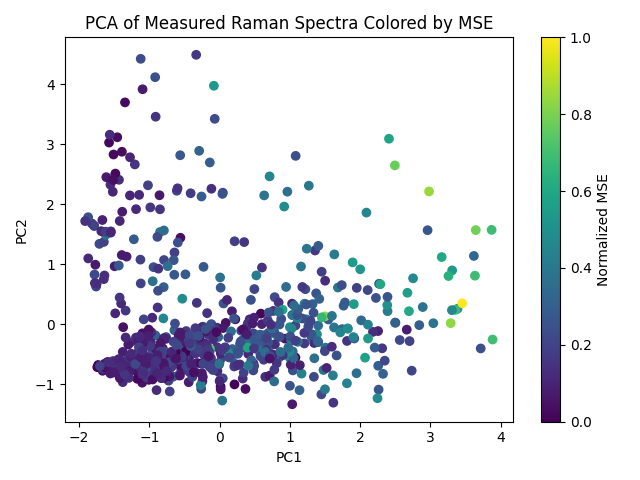

In [5]:
# PCA using chemistries to get first two principal components
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

wavenumber = np.linspace(50, 1700, 1024, endpoint=True)

# MSE (with Density and hardness)
pca = PCA(n_components=5)
spec_pca = pca.fit_transform(spec_true_avg) # shape (M, 5)

# Normalize MSE for coloring
mse_normalized = MinMaxScaler().fit_transform(mse.reshape(-1, 1)).flatten()

# Plot
fig, ax = plt.subplots()
scatter = ax.scatter(spec_pca[:, 0], spec_pca[:, 1], c=mse_normalized, cmap='viridis')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Normalized MSE")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA of Measured Raman Spectra Colored by MSE")

plt.tight_layout()
plt.show()

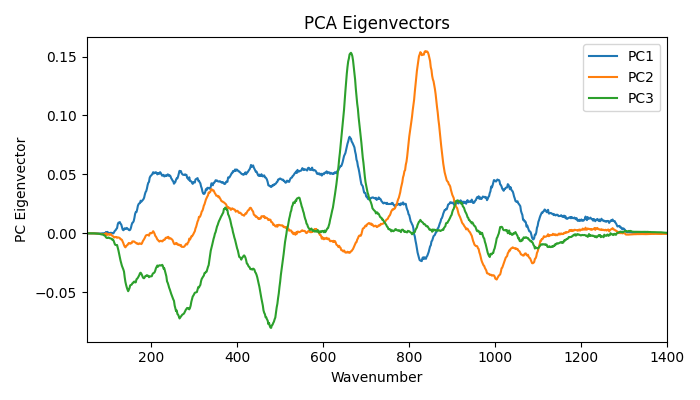

In [6]:
## Eigenvectors for PC1 and PC2
fig, ax = plt.subplots(figsize=(7,4))

# Plot eigenvectors against wavenumber
for i in range(3):
    pci = pca.components_[i]
    ax.plot(wavenumber, pci, label='PC{}'.format(i+1))

ax.set_xlabel("Wavenumber")
ax.set_ylabel("PC Eigenvector")
ax.set_title("PCA Eigenvectors")
ax.set_xlim([50, 1400])
ax.legend()

plt.tight_layout()
plt.show()

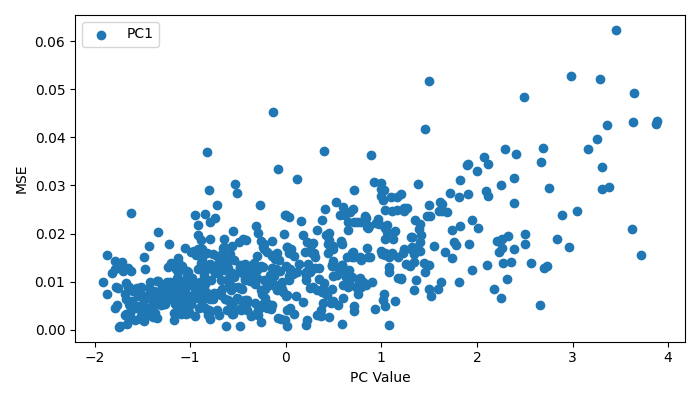

In [7]:
spec_pca[:,0]

## Plot MSE vs PC
fig, ax = plt.subplots(figsize=(7,4))

for i in range(1):
    pc = spec_pca[:,i]
    ax.scatter(pc, mse, label='PC{}'.format(i+1))

ax.set_xlabel("PC Value")
ax.set_ylabel("MSE")
ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# Print the chemistry of the worst 10 predictions

print("Worst 10 MSE Minerals")
idx_largest_mse = np.argpartition(mse, -10)[-10:]
print(idx_largest_mse)
name_minerals = names[idx_largest_mse]
print(name_minerals)

chem_minerals = chem[idx_largest_mse, :]

print
row = '\nOxide\t'
for idx in idx_largest_mse:
    name = names[idx][0:7]
    row += '{}\t'.format(name)
print(row)

for i in range(len(names_oxides)):
    oxide = names_oxides[i]
    row = '{}\t'.format(oxide)
    for idx in idx_largest_mse:
        row += '{:.1f}\t'.format(100*chem[idx,i])
    print(row)


print("\n\nBest 10 MSE Minerals")
idx_lowest_mse = np.argpartition(mse, 10)[:10]
name_minerals = names[idx_lowest_mse]
print(name_minerals)

chem_minerals = chem[idx_lowest_mse, :]

print
row = '\nOxide\t'
for idx in idx_lowest_mse:
    name = names[idx][0:7]
    row += '{}\t'.format(name)
print(row)

for i in range(len(names_oxides)):
    oxide = names_oxides[i]
    row = '{}\t'.format(oxide)
    for idx in idx_lowest_mse:
        row += '{:.1f}\t'.format(100*chem[idx,i])
    print(row)

Worst 10 MSE Minerals
[309 610 248 344 265  11 516 384 197 298]
['Andalusite' 'Augite' 'Analcime' 'Andradite' 'Anatase' 'Actinolite'
 'Arsenopyrite' 'Anglesite' 'Almandine' 'Andalusite']

Oxide	Andalus	Augite	Analcim	Andradi	Anatase	Actinol	Arsenop	Anglesi	Almandi	Andalus	
Al2O3	63.4	5.0	23.1	0.0	0.0	1.1	0.0	0.0	21.8	61.7	
As2O5	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
BaO	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
CO2	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
CaO	0.0	21.8	0.1	33.2	0.0	12.4	0.0	0.0	1.0	0.0	
Cr2O3	0.0	0.0	0.0	1.6	0.0	0.0	0.0	0.0	0.0	0.0	
CuO	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
Fe2O3	0.0	0.0	0.0	29.1	0.0	0.0	0.0	0.0	0.0	0.0	
FeO	0.7	8.3	0.0	0.0	0.0	13.5	0.0	0.0	33.4	0.0	
K2O	0.0	0.0	0.0	0.0	0.0	0.1	0.0	0.0	0.0	0.0	
MgO	0.0	13.3	0.0	0.0	0.0	15.0	0.0	0.0	5.0	0.0	
MnO	0.0	0.2	0.0	0.0	0.0	0.5	0.0	0.0	1.6	1.7	
Na2O	0.0	0.6	13.5	0.0	0.0	0.2	0.0	0.0	0.0	0.0	
P2O5	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
PbO	0.0	0.0	0.0	0.0	0.0	0.0	0.0	74.2	0.0	0.0	
SO3	0.0	0.0	0.0	0.0	0.0	0.0

## Desired Figures
1. <s>Spectrum counting with min and max wavenumber to support choice of wavenumber range</s>
2. <s>Model architecture diagram</s> (not an emphasis here, but could do if needed)
3. prediction of quartz and other high SiO2 mineral (chemistry only and chem + density and hardness)
4. prediction of other spectrum for common minerals with a diverse set of chemistries (4x1 figure = 4 minerals each with predicted with and w/o density and hardness and average measured 'true' spectrum )
5. summary statistics chart (possibly histogram of MSE values) for chem vs chem + density and hardness
6. figure showing highly accurate predictions vs very poor predictions (along with explanation or possible reason why predictions were poor or very good). One possibility for poor predictions is that the chemistry AND density/hardness were were similar among one or more of the training samples when compared to the left out mineral AND the Raman spectrum were not similar at all. In this case, additional features would be needed to distinguish between the results. This hypothesis would be more robust if you found that both the predictions for the closely mathcing chem + density/hardness were poor performers. 

## Generic Figure Properties

### Set Matplotlib Parameters

In [9]:
# Set global Matplotlib style for consistency
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 12,               # font size for axis labels
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 150,
    "savefig.dpi": 600,            # high resolution for saved figure
    "savefig.bbox": "tight",       # remove whitespace
    "axes.spines.top": True,
    "axes.spines.right": True,
    "legend.frameon": False,  # remove legend box
    "legend.fontsize": 10,
    "lines.linewidth": 1.5
})


### Create Figure Function

In [10]:
# Example plotting function
def create_figure(x, y, size_x=4, size_y=3, xlabel='X-axis', ylabel='Y-axis', label='label', filename='test.png', flag_save=False):
    fig, ax = plt.subplots(figsize=(size_x, size_y))  # adjust size for journals (e.g., 4x3 inches)
    ax.plot(x, y, color='black', label=label)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(loc='best')

    plt.tight_layout()  # minimizes padding

    if flag_save: 
        plt.savefig(filename, format='png')  # saved with tight bbox from rcParams
    
    plt.show()


### Example Figure

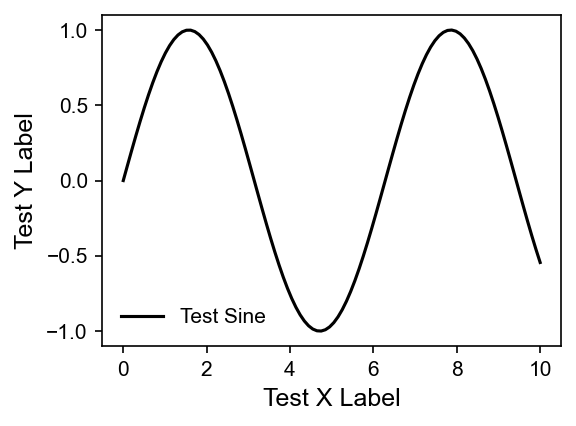

In [11]:
x = np.linspace(0, 10, 100)
y = np.sin(x)

savefile = 'figures' + os.path.sep + 'test.png'
create_figure(x, y, size_x=4, size_y=3, xlabel='Test X Label', ylabel='Test Y Label', label='Test Sine', filename=savefile, flag_save=False)

## Figures

### Figure 1: wavenumber cutoffs histogram

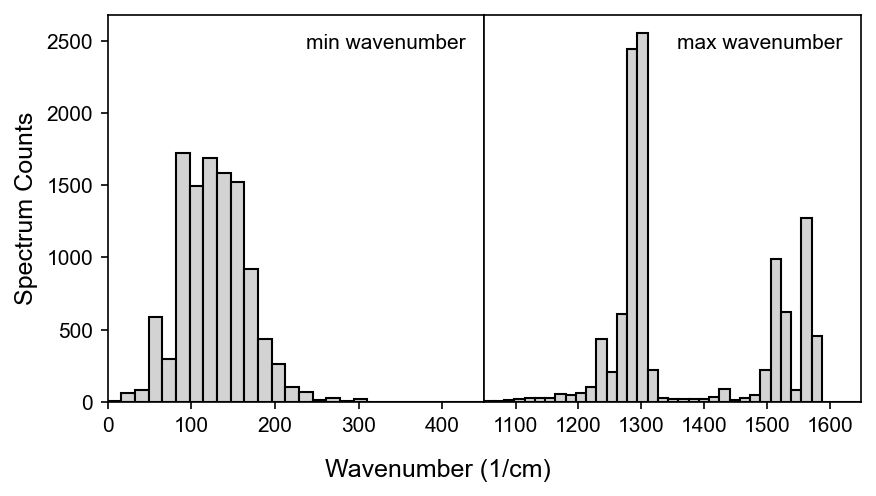

In [12]:
flag_save = False
filename = 'figures' + os.path.sep + 'Figure_1_wavenumber_histogram.png'

# Define bins
bins_min = np.linspace(0, 800, 50, endpoint=True)
bins_max = np.linspace(1000, 1800, 50, endpoint=True)

# Compute histograms to determine shared y-axis limit
min_counts, _ = np.histogram(wavenumber_mins, bins=bins_min)
max_counts, _ = np.histogram(wavenumber_maxs, bins=bins_max)
y_max = max(max(min_counts), max(max_counts)) * 1.05

# Create figure and axes with GridSpec for no spacing
fig = plt.figure(figsize=(6, 3.5))
gs = fig.add_gridspec(1, 2, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.hist(wavenumber_mins, bins=bins_min, label='Min Wavenumber', edgecolor='black', facecolor='lightgray', hatch='')
ax2.hist(wavenumber_maxs, bins=bins_max, label='Max Wavenumber', edgecolor='black', facecolor='lightgray', hatch='')

# Set limits
ax1.set_xlim(0, 450)
ax2.set_xlim(1050, 1650)
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

#ax1.legend(loc='upper right', fontsize=10)
#ax2.legend(loc='upper right', fontsize=10)
ax1.legend(handles=[Patch(facecolor='none', edgecolor='none', label='min wavenumber')], fontsize=10)
ax2.legend(handles=[Patch(facecolor='none', edgecolor='none', label='max wavenumber')], fontsize=10)

ax1.set_ylabel("Spectrum Counts", fontsize=12)
ax2.set_yticks([])
fig.supxlabel("Wavenumber (1/cm)", fontsize=12, y=0.06)

plt.tight_layout()  # minimizes padding

if flag_save: 
    plt.savefig(filename, format='png', dpi=600, bbox_inches='tight')

plt.show()

### Figure 2: high SiO2 predictions (with and w/o density and hardness)

SiO2 index:  16
chem and chem_dh are equal:  True
[1614 1615 1616 1617 1618 1619 3145 3146 3147 3148 3151 3152 3348 3349
 3350 3351 3352 3353 3354 3355 3356 3357 3358 3359 3360 3361 3700 3701
 3702 3703]
['Cristobalite' 'Cristobalite' 'Cristobalite' 'Cristobalite'
 'Cristobalite' 'Cristobalite' 'Opal' 'Opal' 'Opal' 'Opal' 'Opal' 'Opal'
 'Quartz' 'Quartz' 'Quartz' 'Quartz' 'Quartz' 'Quartz' 'Quartz' 'Quartz'
 'Quartz' 'Quartz' 'Quartz' 'Quartz' 'Quartz' 'Quartz' 'Stishovite'
 'Stishovite' 'Stishovite' 'Stishovite']
Number of minerals with SiO2 wt% > 90.0%:  30


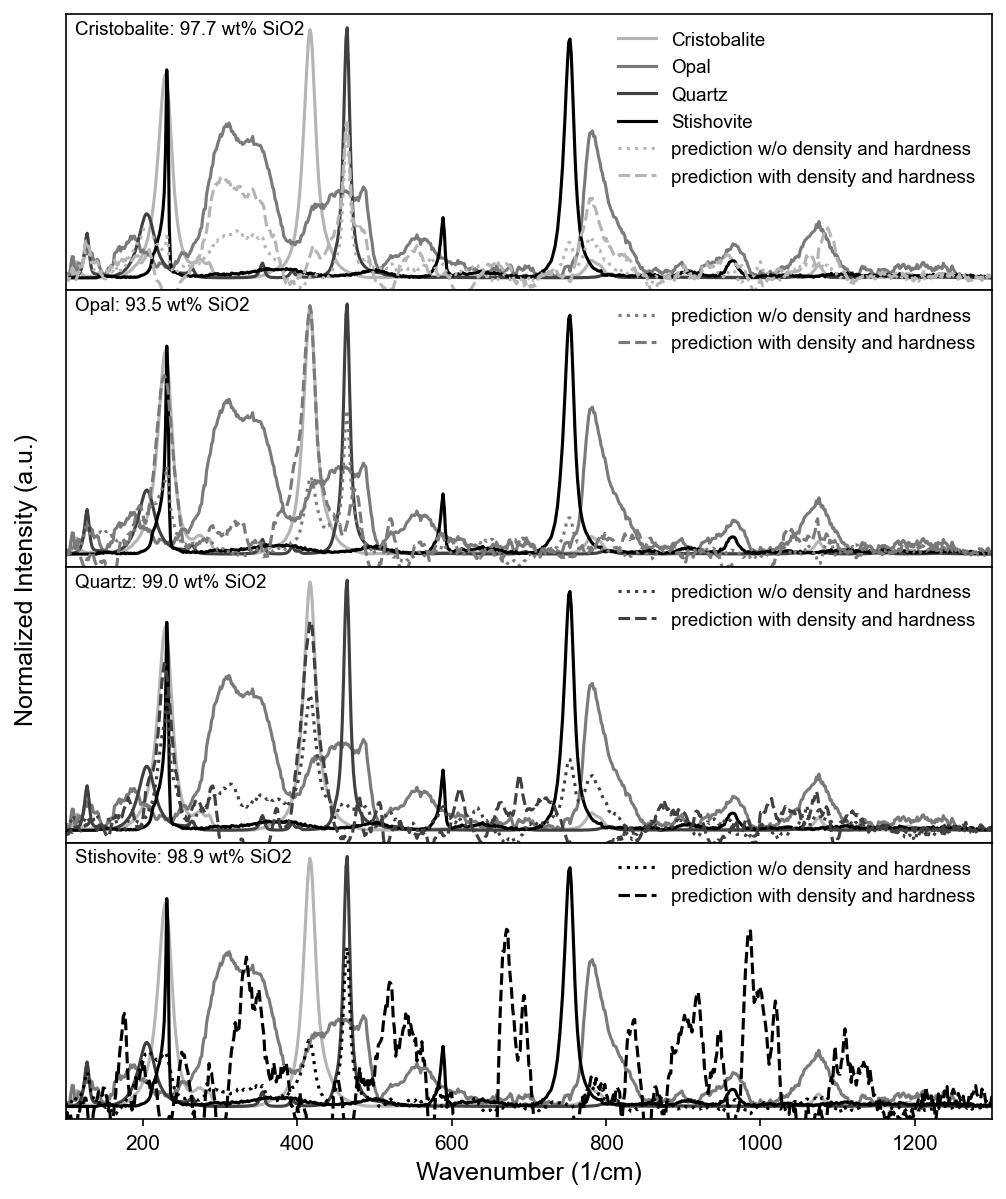

In [16]:
# Find high SiO2 minerals
flag_save = False
filename = 'figures' + os.path.sep + 'Figure_2_SiO2_predictions.png'

# find the index for SiO2 in the oxide names
idx_sio2 = np.where(names_oxides == 'SiO2')[0][0]
print('SiO2 index: ', idx_sio2)

equal = np.array_equal(chem_dh[:,0:20], chem)
print("chem and chem_dh are equal: ", equal)

# Find all spectrum where the chemistry has a high amount of SiO2
thresh = 0.9
idx_high_sio2 = np.where(chem[:,idx_sio2] > thresh)[0]
print(idx_high_sio2)

# Get all mineral names associated with high SiO2 chemistry
names_high_sio2 = names[idx_high_sio2]
print(names_high_sio2)
print("Number of minerals with SiO2 wt% > {}%: ".format(thresh*100), len(names_high_sio2))

wavenumber = np.linspace(50, 1700, 1024, endpoint=True)

# Keep track of first occurrence of each mineral name
plotted_dh = set()
plotted = set()

# Create color mapping for consistent coloring
unique_names = np.unique(names_high_sio2)
gray_colors = plt.cm.Greys(np.linspace(0.4, 1, len(unique_names)))
color_map = {name: color for name, color in zip(unique_names, gray_colors)}

# Precompute all average true spectra and first predictions
avg_true_dh = {}
avg_true = {}
first_pred_dh = {}
first_pred = {}

for name in unique_names:
    idxs = idx_high_sio2[names_high_sio2 == name]
    avg_true_dh[name] = spec_true_dh[idxs].mean(axis=0)
    avg_true[name] = spec_true[idxs].mean(axis=0)
    first_pred_dh[name] = spec_predicted_dh[idxs[0]]
    first_pred[name] = spec_predicted[idxs[0]]

# Create one plot per mineral
fig, ax = plt.subplots(4, 1, figsize=(7, 8))
plt.tight_layout()
    
cnt = 0
for name_pred in unique_names:
    color_pred = color_map[name_pred]

    # Get indices and compute average SiO2 for this mineral
    idxs = idx_high_sio2[names_high_sio2 == name_pred]
    avg_sio2 = chem[idxs, idx_sio2].mean()
    label_text = f'{name_pred}: {avg_sio2*100:.1f} wt% SiO2'

    # Plot average true spectra for all minerals
    for name in unique_names:
        color = color_map[name]
        if cnt == 0:
            ax[cnt].plot(wavenumber, avg_true[name], color=color, label=f'{name}')
        else:
            ax[cnt].plot(wavenumber, avg_true[name], color=color)

    # Plot predictions only for this mineral
    ax[cnt].plot(wavenumber, first_pred[name_pred], color=color_pred, linestyle=':', label='prediction w/o density and hardness')
    ax[cnt].plot(wavenumber, first_pred_dh[name_pred], color=color_pred, linestyle='--', label='prediction with density and hardness')
    

    ax[cnt].set_xlim([100, 1300])
    ax[cnt].set_ylim([-0.05, 1.05])

    if cnt != len(unique_names)-1:
        ax[cnt].set_xticks([])
    else:
        ax[cnt].set_xlabel('Wavenumber (1/cm)', fontsize=12)

    #if cnt == 0:
    #    ax[cnt].legend(loc='upper right', fontsize=8)

    ax[cnt].set_yticks([])
    #ax[cnt].set_title(f'{name_pred} (avg SiO2: {avg_sio2*100:.2f} wt%)')
    ax[cnt].set_ylabel(' ', fontsize=12)
    ax[cnt].legend(loc='upper right', fontsize=9)

    # SiO2 wt% text
    ax[cnt].text(
        0.01, 0.98, label_text,
        transform=ax[cnt].transAxes,
        ha='left', va='top',
        fontsize=9,
        bbox=dict(facecolor='none', alpha=0.7, edgecolor='none')
    )
    

    cnt += 1
    
fig.subplots_adjust(hspace=0)
fig.supylabel("Normalized Intensity (a.u.)", fontsize=12, x=0.03)


if flag_save: 
    plt.savefig(filename, format='png', dpi=600, bbox_inches='tight')

plt.show()


### Figure 3: Other predicted spectra (with and w/o density and hardness)

In [14]:
# Find high SiO2 minerals
flag_save = False
filename = 'figures' + os.path.sep + 'Figure_3_other_predictions.png'

import sys

N = 10
top_n = Counter(names).most_common(10)

rows = []
for name, count in top_n:
    print("{}: {}".format(name, count))

    # select first instance to get chemistry
    idx = np.where(names == name)[0][0] 
    chem_mineral = chem_dh[idx]

    row = dict(zip(names_oxides_dh, chem_mineral))
    row['name'] = name
    #row['Count'] = count
    rows.append(row)

df = pd.DataFrame(rows)

# Move 'name' columns to the front
cols = ['name'] + [col for col in names_oxides_dh if col in df.columns]
df = df[cols]

# Print
print("\n")
print(df.to_string(index=False, float_format="%.1f"))

sys.exit()

wavenumber = np.linspace(50, 1700, 1024, endpoint=True)

# Keep track of first occurrence of each mineral name
plotted_dh = set()
plotted = set()

# Create color mapping for consistent coloring
unique_names = np.unique(names_high_sio2)
gray_colors = plt.cm.Greys(np.linspace(0.4, 1, len(unique_names)))
color_map = {name: color for name, color in zip(unique_names, gray_colors)}

# Precompute all average true spectra and first predictions
avg_true_dh = {}
avg_true = {}
first_pred_dh = {}
first_pred = {}

for name in unique_names:
    idxs = idx_high_sio2[names_high_sio2 == name]
    avg_true_dh[name] = spec_true_dh[idxs].mean(axis=0)
    avg_true[name] = spec_true[idxs].mean(axis=0)
    first_pred_dh[name] = spec_predicted_dh[idxs[0]]
    first_pred[name] = spec_predicted[idxs[0]]

# Create one plot per mineral
fig, ax = plt.subplots(4, 1, figsize=(7, 8))
plt.tight_layout()
    
cnt = 0
for name_pred in unique_names:
    color_pred = color_map[name_pred]

    # Get indices and compute average SiO2 for this mineral
    idxs = idx_high_sio2[names_high_sio2 == name_pred]
    avg_sio2 = chem[idxs, idx_sio2].mean()
    label_text = f'{name_pred}: {avg_sio2*100:.1f} wt% SiO2'

    # Plot average true spectra for all minerals
    for name in unique_names:
        color = color_map[name]
        if cnt == 0:
            ax[cnt].plot(wavenumber, avg_true[name], color=color, label=f'{name}')
        else:
            ax[cnt].plot(wavenumber, avg_true[name], color=color)

    # Plot predictions only for this mineral
    ax[cnt].plot(wavenumber, first_pred[name_pred], color=color_pred, linestyle=':', label='prediction w/o density and hardness')
    ax[cnt].plot(wavenumber, first_pred_dh[name_pred], color=color_pred, linestyle='--', label='prediction with density and hardness')
    

    ax[cnt].set_xlim([100, 1300])
    ax[cnt].set_ylim([-0.05, 1.05])

    if cnt != len(unique_names)-1:
        ax[cnt].set_xticks([])
    else:
        ax[cnt].set_xlabel('Wavenumber (1/cm)', fontsize=12)

    #if cnt == 0:
    #    ax[cnt].legend(loc='upper right', fontsize=8)

    ax[cnt].set_yticks([])
    #ax[cnt].set_title(f'{name_pred} (avg SiO2: {avg_sio2*100:.2f} wt%)')
    ax[cnt].set_ylabel(' ', fontsize=12)
    ax[cnt].legend(loc='upper right', fontsize=9)

    # SiO2 wt% text
    ax[cnt].text(
        0.01, 0.98, label_text,
        transform=ax[cnt].transAxes,
        ha='left', va='top',
        fontsize=9,
        bbox=dict(facecolor='none', alpha=0.7, edgecolor='none')
    )
    

    cnt += 1
    
fig.subplots_adjust(hspace=0)
fig.supylabel("Normalized Intensity (a.u.)", fontsize=12, x=0.03)


if flag_save: 
    plt.savefig(filename, format='png', dpi=600, bbox_inches='tight')

plt.show()


Beryl: 83
Forsterite: 78
Grossular: 76
Diopside: 61
Cerussite: 59
Calcite: 58
Rhodonite: 57
Dolomite: 50
Albite: 46
Andradite: 46


      name  Al2O3  As2O5  BaO  CO2  CaO  Cr2O3  CuO  Fe2O3  FeO  K2O  MgO  MnO  Na2O  P2O5  PbO  SO3  SiO2  SrO  TiO2  ZnO   d   h
     Beryl    0.2    0.0  0.0  0.0  0.0    0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.7  0.0   0.0  0.0 2.8 7.8
Forsterite    0.0    0.0  0.0  0.0  0.0    0.0  0.0    0.0  0.1  0.0  0.5  0.0   0.0   0.0  0.0  0.0   0.4  0.0   0.0  0.0 3.3 6.5
 Grossular    0.2    0.0  0.0  0.0  0.4    0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.4  0.0   0.0  0.0 3.6 7.0
  Diopside    0.0    0.0  0.0  0.0  0.2    0.0  0.0    0.0  0.0  0.0  0.2  0.0   0.0   0.0  0.0  0.0   0.5  0.0   0.0  0.0 3.4 6.0
 Cerussite    0.0    0.0  0.0  0.2  0.0    0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.8  0.0   0.0  0.0   0.0  0.0 6.6 3.2
   Calcite    0.0    0.0  0.0  0.5  0.5    0.0  0.0    0.0  0.0  0.0  0.0  0.0   0

SystemExit: 

/Users/danielvanhoesen/anaconda3/envs/raman/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
